In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Squash warning messages for cleaner output in the notebook
import warnings
warnings.showwarning = lambda *args, **kwargs: None

In [2]:
sys.path.insert(1, '../') #utils is in parent folder
import utils

In [3]:
# This is only needed when we run in a Jupyter notebook and the external files are changed
import importlib
importlib.reload(utils)

<module 'utils' from '..\\utils.py'>

## Read in data and shape it to a format that we can process

In [6]:
local_data_folder = '..\data'
datafile = os.path.join(local_data_folder, 'nyc_energy.csv')
df = pd.read_csv(datafile, header=0, low_memory=False, parse_dates=True)
df.head()

,dtime,nycdemand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [7]:
df.shape

(49205, 4)

In [8]:
for col in df.columns: 
    print(col, df[col].dtypes)

dtime object
nycdemand float64
precip float64
temp float64


In [9]:
display(df.count())

dtime        49205
nycdemand    49124
precip       48975
temp         49019
dtype: int64

Drop data with null timestamp if there's any

In [10]:
time_column_name = 'dtime'

In [11]:
df[df[time_column_name].isnull()]

,dtime,nycdemand,precip,temp


In [12]:
df.dropna(subset=[time_column_name], inplace=True)

### Compute time columns

In [13]:
df[time_column_name]= pd.to_datetime(df[time_column_name])
df.head()

,dtime,nycdemand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


## Clean the data
* **Remove rows with duplicate timestamps**
* **Fill missing timestamps**
* **Remove outliers (negatives, zeros, values beyond 3 stdev)**
* **Fill missing target values by interpolation (using 2 closest non-missing values with a limit of max 6 consequtive missing values)**

In [14]:
target_column_name = 'nycdemand'

In [15]:
# remove all rows before the first non-null, and after the last non-null
dfnotna = df[df[target_column_name].notna()]
if len(dfnotna) <= 0:
    raise Exception('{} does not have valid data'.format(target_column_name))
    
data_begin = dfnotna.iloc[0][time_column_name]
data_end = dfnotna.iloc[-1][time_column_name]
df = df[(df[time_column_name] >= data_begin) & (df[time_column_name] <= data_end)]
df.head()

,dtime,nycdemand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [16]:
display(df.count())

dtime        49156
nycdemand    49124
precip       48926
temp         48970
dtype: int64

In [17]:
# check if we have dupliate timestamps
df[df[time_column_name].duplicated()].head()

,dtime,nycdemand,precip,temp


In [18]:
# Show rows with duplicate timestamps if any
duplicate_time_rows = df[df[time_column_name].duplicated()].count()[0]
duplicate_time_rows

0

In [19]:
# examine a duplicate sample
#df.loc[df[time_column_name] == 'output_timestamp_from_above_cell']

In [20]:
# Drop rows with duplicate datetime
df = df[~df[time_column_name].duplicated(keep='first')]
df[df[time_column_name].duplicated()]

,dtime,nycdemand,precip,temp


In [21]:
# Build full range of timestamps
min_time, max_time = df[time_column_name].min(), df[time_column_name].max()

In [22]:
dt_idx = pd.date_range(min_time, max_time, freq='H')
dt_idx

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2017-08-09 20:00:00', '2017-08-09 21:00:00',
               '2017-08-09 22:00:00', '2017-08-09 23:00:00',
               '2017-08-10 00:00:00', '2017-08-10 01:00:00',
               '2017-08-10 02:00:00', '2017-08-10 03:00:00',
               '2017-08-10 04:00:00', '2017-08-10 05:00:00'],
              dtype='datetime64[ns]', length=49158, freq='H')

In [23]:
# Reindex to fill the time series gaps
df.index = pd.DatetimeIndex(df[time_column_name])
df = df.reindex(dt_idx)  

In [24]:
df.head()

,dtime,nycdemand,precip,temp
2012-01-01 00:00:00,2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,2012-01-01 04:00:00,4275.5,0.0,42.61


In [25]:
df.drop(time_column_name, axis=1, inplace=True)

In [26]:
# Inserted records have null values for all columns
df_missing = df[df.isnull().all(axis=1)]
df_missing.head()

,nycdemand,precip,temp
2016-03-13 02:00:00,NaN,NaN,NaN
2017-03-12 02:00:00,NaN,NaN,NaN


In [27]:
missing_timeslot_count = len(df_missing)
missing_timeslot_count

2

Before interpolate, remove outliers. Outliers are those rows with target values that are not null and are above +/- 3 standard deviations, or are less equal 0.

In [28]:
target_mean = df[target_column_name].mean()
target_stdev = df[target_column_name].std()
outlier = df.loc[(np.abs(df[target_column_name]-target_mean) > (3*target_stdev)) & ~(df[target_column_name].isnull()), target_column_name]
df.loc[outlier.index, target_column_name] = np.nan
zeroneg = df.loc[df[target_column_name] <= 0, target_column_name]
df.loc[zeroneg.index, target_column_name] = np.nan
outlier_count = outlier.count()
zeroneg_count = zeroneg.count()
outlier_count, zeroneg_count

(414, 0)

Fill missing values by interpolating between the two closest non-missing values. Use a quadratic function and set a limit of 6. This limit means that if more than 6 missing values occur consecutively, the missing values are not interpolated over and they remain missing. This is to avoid spurious interpolation between very distant time periods.

In [29]:
df = df.interpolate(limit=6, method='linear')

In [30]:
null_row_count_after_interpolation = df[target_column_name].isnull().sum()
null_row_count_after_interpolation

96

In [31]:
# Fill the still-missing values with mean
df.fillna(target_mean, inplace=True)

Check demand distribution and auto-correlation to see if there's any pattern at all, or random

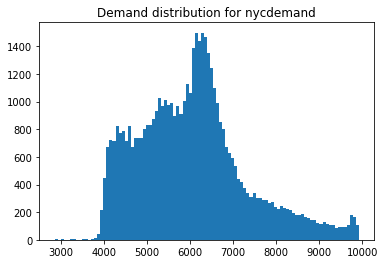

In [32]:
plt.hist(df[target_column_name], bins=100)
plt.title('Demand distribution for ' + target_column_name)
plt.show()

In [33]:
#save the processed file locally
df.to_csv(os.path.join(local_data_folder, target_column_name + '_hourly.csv'), index_label=time_column_name, float_format='%.3f')

## Aggregate data based on periodicity:

* daily (hourly pattern repeated every day)
* weekly (daily pattern repeated every week)
* yearly (monthly pattern repeated every year)

daily

In [34]:
dfday = df[[target_column_name]].groupby(pd.Grouper(freq=timedelta(days=1))).agg({target_column_name: 'sum'})

In [35]:
# There shouldn't be na data after aggregation, but still possbility to have outliers, ex. if we only have data
# for a few hours a day, hourly data will appear normal, but daily data will be abnormal, still need to remove
# outliers after aggregation
target_mean = dfday[target_column_name].mean()
target_stdev = dfday[target_column_name].std()
outlier = dfday.loc[(np.abs(dfday[target_column_name]-target_mean) > (3*target_stdev)) & ~(dfday[target_column_name].isnull()), target_column_name]
dfday.loc[outlier.index, target_column_name] = np.nan
zeroneg = dfday.loc[dfday[target_column_name] <= 0, target_column_name]
dfday.loc[zeroneg.index, target_column_name] = np.nan
outlier_count = outlier.count()
zeroneg_count = zeroneg.count()
outlier_count, zeroneg_count

(3, 0)

In [36]:
dfday = dfday.interpolate(limit=6, method='linear')

In [37]:
null_row_count_after_interpolation = dfday[target_column_name].isnull().sum()
null_row_count_after_interpolation

0

In [38]:
dfday.fillna(target_mean, inplace=True)

In [39]:
dfday.to_csv(os.path.join(local_data_folder, target_column_name + '_daily.csv'), index_label=time_column_name, float_format='%.3f')

monthly

In [40]:
dfmonth = df[[target_column_name]].groupby(pd.Grouper(freq='M')).agg({target_column_name: 'sum'})

In [41]:
target_mean = dfmonth[target_column_name].mean()
target_stdev = dfmonth[target_column_name].std()
outlier = dfmonth.loc[(np.abs(dfmonth[target_column_name]-target_mean) > (3*target_stdev)) & ~(dfmonth[target_column_name].isnull()), target_column_name]
dfmonth.loc[outlier.index, target_column_name] = np.nan
zeroneg = dfmonth.loc[dfmonth[target_column_name] <= 0, target_column_name]
dfmonth.loc[zeroneg.index, target_column_name] = np.nan
outlier_count = outlier.count()
zeroneg_count = zeroneg.count()
outlier_count, zeroneg_count

(1, 0)

In [42]:
dfmonth = dfmonth.interpolate(limit=6, method='linear')

In [43]:
null_row_count_after_interpolation = dfmonth[target_column_name].isnull().sum()
null_row_count_after_interpolation

0

In [44]:
dfmonth.fillna(target_mean, inplace=True)

In [45]:
dfmonth.to_csv(os.path.join(local_data_folder, target_column_name + '_monthly.csv'), index_label=time_column_name, float_format='%.3f')

## Create lags - only needed for manual ML models.  AutoML and ARIMA don't need it.

**Create lags for hourly analysis**

In [46]:
delta = timedelta(hours=1)
frequency = 24 # hourly pattern repeated daily
dfhour = df[[target_column_name]] # select a single column (single brackets) returns a series, multi columns returns a dataframe
dfhour.head()

,nycdemand
2012-01-01 00:00:00,4937.5
2012-01-01 01:00:00,4752.1
2012-01-01 02:00:00,4542.6
2012-01-01 03:00:00,4357.7
2012-01-01 04:00:00,4275.5


Auto-correlation plot indicates whether the timeseries is highly correlated with itself based on lag, or if the changes are random. Visualize the chart to see what are the closest periods/lags that have the highest autocorrelation.

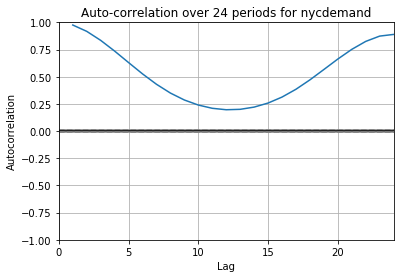

In [47]:
utils.plot_auto_correlation(dfhour, target_column_name, frequency)

In [48]:
lag = 2 
utils.generate_lagged_features(dfhour, target_column_name, lag, delta)
dfhour.head()

,nycdemand,nycdemand_lag1,nycdemand_lag2
2012-01-01 00:00:00,4937.5,NaN,NaN
2012-01-01 01:00:00,4752.1,4937.5,NaN
2012-01-01 02:00:00,4542.6,4752.1,4937.5
2012-01-01 03:00:00,4357.7,4542.6,4752.1
2012-01-01 04:00:00,4275.5,4357.7,4542.6


In [50]:
dfhour.dropna(how='any', inplace=True)
dfhour.to_csv(os.path.join(local_data_folder, target_column_name + '_hourly_lags.csv'), index_label=time_column_name, float_format='%.3f')

**Create lags for daily analysis**

In [51]:
delta = timedelta(days=1)
frequency = 7 # daily patterns repeated weekly
dfday.head()

,nycdemand
2012-01-01,118916.0
2012-01-02,127270.9
2012-01-03,146292.3
2012-01-04,152070.4
2012-01-05,147125.9


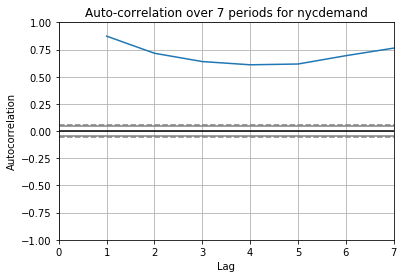

In [52]:
utils.plot_auto_correlation(dfday, target_column_name, frequency)

In [53]:
lag = 2
utils.generate_lagged_features(dfday, target_column_name, lag, delta)
dfday.head()

,nycdemand,nycdemand_lag1,nycdemand_lag2
2012-01-01,118916.0,NaN,NaN
2012-01-02,127270.9,118916.0,NaN
2012-01-03,146292.3,127270.9,118916.0
2012-01-04,152070.4,146292.3,127270.9
2012-01-05,147125.9,152070.4,146292.3


In [54]:
dfday.dropna(how='any', inplace=True)
dfday.to_csv(os.path.join(local_data_folder, target_column_name + '_daily_lags.csv'), index_label=time_column_name, float_format='%.3f')

**Create features for monthly analysis**

In [55]:
delta = 'M'
frequency = 12 # monthly patterns repeated yearly
dfmonth.head()

,nycdemand
2012-01-31,4283576.90
2012-02-29,3913142.80
2012-03-31,4075987.15
2012-04-30,3865641.00
2012-05-31,4365714.70


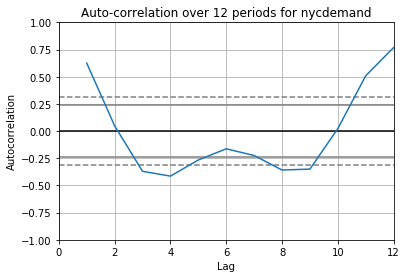

In [56]:
utils.plot_auto_correlation(dfmonth, target_column_name, frequency)

In [57]:
lag = 1
utils.generate_lagged_features(dfmonth, target_column_name, lag, delta)
dfmonth.head()

,nycdemand,nycdemand_lag1
2012-01-31,4283576.90,NaN
2012-02-29,3913142.80,4283576.90
2012-03-31,4075987.15,3913142.80
2012-04-30,3865641.00,4075987.15
2012-05-31,4365714.70,3865641.00


In [59]:
dfmonth.dropna(how='any', inplace=True)
dfmonth.to_csv(os.path.join(local_data_folder, target_column_name + '_monthly_lags.csv'), index_label=time_column_name, float_format='%.3f')